<a href="https://colab.research.google.com/github/akilasadhish/Remote-sensing-scene-classification/blob/master/RSSCinceptionv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from contextlib import suppress
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import os

import warnings
from zipfile import ZipFile

from skimage.io import imread, imsave

from keras import applications
from keras import optimizers
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, classification_report

%matplotlib inline

In [2]:
with suppress(FileExistsError):
    os.mkdir('data')

source_dir = os.path.join('data', 'UCMerced_LandUse', 'Images')

!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip 
if not os.path.isdir(source_dir):
    with ZipFile('UCMerced_LandUse.zip') as z:
        z.extractall(path='data')

--2021-03-16 05:50:58--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip’

UCMerced_LandUse.zi 100%[===================>] 317.07M  17.5MB/s    in 32s     

2021-03-16 05:51:31 (9.84 MB/s) - ‘UCMerced_LandUse.zip’ saved [332468434/332468434]



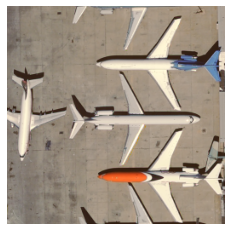

(256, 256, 3)


In [3]:
import cv2
plt.imshow(imread('data/UCMerced_LandUse/Images/airplane/airplane90.tif'))
plt.axis('off')
plt.show()
im = cv2.imread("data/UCMerced_LandUse/Images/airplane/airplane90.tif")
print(im.shape)

In [4]:
# Set random seed for reproducibility
np.random.seed(8)

### Randomly assign each image to train, validate, or test folder, segregated by class name

In [5]:
"""
Create image directory hierarchy that looks like this:
./data/flow/
            train/
                  agriculture/
                  airplane/
                  ...
            validate/
                     agriculture/
                     airplane/
                     ...
            test/
                 agriculture/
                 airplane/
                 ...
"""

# Collect class names from directory names in './data/UCMerced_LandUse/Images/'
class_names = os.listdir(source_dir)    

# Create path to image "flow" base directory
flow_base = os.path.join('data', 'flow')

# Create pathnames to train/validate/test subdirectories
target_dirs = {target: os.path.join(flow_base, target) for target in ['train', 'validate', 'test']}

if not os.path.isdir(flow_base):

    # Make new directories
    os.mkdir(flow_base)
    
    for target in ['train', 'validate', 'test']:
        target_dir = os.path.join(flow_base, target)
        os.mkdir(target_dir)
        for class_name in class_names:
            class_subdir = os.path.join(target_dir, class_name)
            os.mkdir(class_subdir)

    # suppress low-contrast warning from skimage.io.imsave
    warnings.simplefilter('ignore', UserWarning)
    
    # Copy images from ./data/UCMerced_LandUse/Images to ./data/flow/<train, validate, test>    
    for root, _, filenames in os.walk(source_dir):
        if filenames:
            class_name = os.path.basename(root)

            # Randomly shuffle filenames
            filenames = np.random.permutation(filenames)
            for target, count in [('train', 80), ('validate', 10), ('test', 10)]:
                target_dir = os.path.join(flow_base, target, class_name)
                for filename in filenames[:count]:
                    filepath = os.path.join(root, filename)
                    image = imread(filepath)
                    basename, _ = os.path.splitext(filename)
                    # Convert TIF to PNG to work with Keras ImageDataGenerator.flow_from_directory
                    target_filename = os.path.join(target_dir, basename + '.png')
                    imsave(target_filename, image)
            
                filenames = filenames[count:]
    
    # Show future warnings during development
    warnings.resetwarnings()

### Calculate the training image means by channel

In [6]:
class_names

['mobilehomepark',
 'freeway',
 'chaparral',
 'baseballdiamond',
 'denseresidential',
 'golfcourse',
 'intersection',
 'sparseresidential',
 'runway',
 'beach',
 'agricultural',
 'overpass',
 'river',
 'buildings',
 'forest',
 'airplane',
 'storagetanks',
 'harbor',
 'parkinglot',
 'tenniscourt',
 'mediumresidential']

In [7]:
means = []
for root, _, filenames in os.walk(target_dirs['train']):
    for filename in filenames:
        filepath = os.path.join(root, filename)
        image = imread(filepath)
        means.append(np.mean(image, axis=(0, 1)))
channel_means = np.mean(means, axis=0)

# Get training set bottleneck features from pretrained CNN

In [8]:
def get_bottleneck_features(model, dataset, preproc_func, batch_size=32):
    """
    Get botteleneck features X and labels Y for the input dataset (train/validate/test)
    by predicting on the convolutional portion only of a pretrained model.
    
    Note: Saves features and labels to numpy files for future use when rerunning the code.
        
    Inputs:
        model: Pre-trained deep learning model, excluding fully-connected top model
               e.g. applications.VGG16(include_top=False, weights='imagenet')
        dataset = string label for dataset image directory ['train', 'validate', 'test']
        preproc_func: preprocessing function implied to each input sample
        batch_size: number of image samples per batch
    
    Return:
        Return bottleneck features as numpy.array
    """

    print(f'Generating "{dataset}" bottleneck predictions')
    X_filepath = os.path.join('data', 'bn_' + dataset + '_X.npy')
    y_filepath = os.path.join('data', 'bn_' + dataset + '_y.npy')

    # Check if data are available from disk.
    try:
        with open(X_filepath, 'rb') as f:
            X = np.load(f)
        with open(y_filepath, 'rb') as f:
            y = np.load(f)
            Y = to_categorical(y, num_classes=len(np.unique(y)))
    # Else, get the bottleneck features and labels
    except:
        image_data_gen = ImageDataGenerator(rescale=1/255.0, preprocessing_function=preproc_func)
        image_generator = image_data_gen.flow_from_directory(target_dirs[dataset],
                                                             batch_size=batch_size,
                                                             shuffle=False
                                                             )
        image_count = 0
        X_batches, Y_batches = [], []
        for X, Y in image_generator:
            X_batches.append(model.predict_on_batch(X))
            Y_batches.append(Y)
            image_count += X.shape[0]
            # Must interrupt image_generator
            if image_count >= image_generator.n:
                break

        X = np.concatenate(X_batches)
        with open(X_filepath, 'wb') as f:
            np.save(f, X) 
        Y = np.concatenate(Y_batches)
        y = np.nonzero(Y)[1]
        with open(y_filepath, 'wb') as f:
            np.save(f, y)
    
    print(f'   Features of shape {X.shape} extracted for model "{model.name}"')
    return X, Y

### Select a pre-trained model from the Keras.applications module; e.g. Xception, VGG16 ...

In [9]:
# Let's try the VGG16 model
pretrained_model = applications.InceptionV3(include_top=False, weights='imagenet')

87916544/87910968 [==============================] - 1s 0us/step


### Extract bottleneck features for each dataset: train, validate, and test

In [10]:
num_classes = len(class_names)
X, Y = dict(), dict()
preprocess = lambda x: x - channel_means
for dataset in ['train', 'validate', 'test']:
    # Extract bottleneck features from pretrained model, predicting from "dataset" directory
    X[dataset], Y[dataset] = get_bottleneck_features(pretrained_model, dataset, preprocess)

Generating "train" bottleneck predictions
Found 1680 images belonging to 21 classes.
   Features of shape (1680, 6, 6, 2048) extracted for model "inception_v3"
Generating "validate" bottleneck predictions
Found 210 images belonging to 21 classes.
   Features of shape (210, 6, 6, 2048) extracted for model "inception_v3"
Generating "test" bottleneck predictions
Found 210 images belonging to 21 classes.
   Features of shape (210, 6, 6, 2048) extracted for model "inception_v3"


# Train a fully-connected model using bottleneck features

In [11]:
def build_fully_connected(input_shape, num_classes):
    """
    Create a fully-connected model to train or test on UC Merced dataset.
    """
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [12]:
 # Build, compile, and fit the model
from tensorflow.keras.optimizers import RMSprop

model = build_fully_connected(input_shape=X['train'].shape[1:], num_classes=num_classes)
adam = optimizers.RMSprop(lr=0.0005)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_fit_history = model.fit(X['train'], Y['train'], batch_size=64, epochs=30,
                              verbose=2, validation_data=(X['validate'], Y['validate']))

Epoch 1/30
27/27 - 6s - loss: 9.4753 - accuracy: 0.2220 - val_loss: 3.2894 - val_accuracy: 0.3143
Epoch 2/30
27/27 - 5s - loss: 3.6133 - accuracy: 0.3101 - val_loss: 1.7338 - val_accuracy: 0.4333
Epoch 3/30
27/27 - 5s - loss: 2.1777 - accuracy: 0.4452 - val_loss: 1.9287 - val_accuracy: 0.5238
Epoch 4/30
27/27 - 5s - loss: 1.7328 - accuracy: 0.5321 - val_loss: 1.7376 - val_accuracy: 0.5381
Epoch 5/30
27/27 - 5s - loss: 1.4429 - accuracy: 0.6220 - val_loss: 1.0550 - val_accuracy: 0.7000
Epoch 6/30
27/27 - 5s - loss: 1.2859 - accuracy: 0.6815 - val_loss: 1.8224 - val_accuracy: 0.6048
Epoch 7/30
27/27 - 5s - loss: 0.8955 - accuracy: 0.7554 - val_loss: 0.5370 - val_accuracy: 0.8286
Epoch 8/30
27/27 - 5s - loss: 0.8812 - accuracy: 0.7810 - val_loss: 0.8892 - val_accuracy: 0.7952
Epoch 9/30
27/27 - 5s - loss: 0.5948 - accuracy: 0.8470 - val_loss: 0.7259 - val_accuracy: 0.8286
Epoch 10/30
27/27 - 5s - loss: 0.5739 - accuracy: 0.8518 - val_loss: 0.6867 - val_accuracy: 0.8286
Epoch 11/30
27/27 -

### Plot training loss vs. validation loss

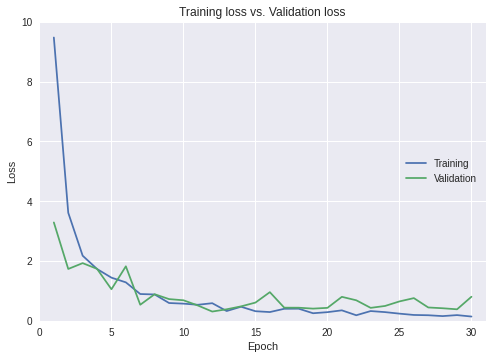

In [13]:
matplotlib.style.use('seaborn')
epochs = len(model_fit_history.history['loss'])
max_loss = max(max(model_fit_history.history['loss']), max(model_fit_history.history['val_loss']))
plt.axis([0, epochs+1, 0, round(max_loss * 2.0) / 2 + 0.5])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['loss'])
plt.plot(x, model_fit_history.history['val_loss'])
plt.title('Training loss vs. Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

### Plot of training accuracy vs. validation accuracy

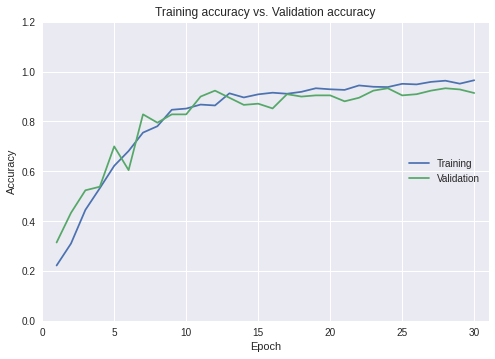

In [14]:
matplotlib.style.use('seaborn')
epochs = len(model_fit_history.history['accuracy'])
plt.axis([0, epochs+1, 0, 1.2])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['accuracy'])
plt.plot(x, model_fit_history.history['val_accuracy'])
plt.title('Training accuracy vs. Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

<hr>

### Retrain model on training + validation sets, through epoch with smallest validation loss.

In [15]:
epochs = np.argmin(model_fit_history.history['val_loss']) + 1
print(f'Stop training at {epochs} epochs')

# Merge training and validation data
X_train = np.concatenate([X['train'], X['validate']])
Y_train = np.concatenate([Y['train'], Y['validate']])

# Randomly shuffle X and Y
shuffle_index = np.random.permutation(len(X_train))
X_train = X_train[shuffle_index]
Y_train = Y_train[shuffle_index]
model = build_fully_connected(input_shape=X_train.shape[1:], num_classes=num_classes)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_fit_history = model.fit(X_train, Y_train, batch_size=64, epochs=epochs, verbose=0)
model.summary()
#img = load_image('/content/data/flow/test/chaparral/chaparral36.png')
#result = model.predict(img)
#model.save("finalmodel.h5")

Stop training at 12 epochs
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               18874624  
_________________________________________________________________
activation_95 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 21)                5397      
Total params: 18,880,021
Trainable params: 18,880,021
Non-trainable params: 0
_________________________________________________________________


In [43]:

class_names1 = ['agricultural','airplane','baseballdiamond','beach','buildings','chaparral','denseresidential','forest','freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt' ]



### Evaluate trained model on the test images

In [49]:
def get_bottleneck_features(model, img, preproc_func, batch_size=64):
    # Check if data are available from disk.
    try:
        with open(X_filepath, 'rb') as f:
            X = np.load(f)
    except:
        image_data_gen = ImageDataGenerator(rescale=1/255.0, preprocessing_function=preproc_func)
        image_generator = image_data_gen.flow(img, batch_size=batch_size, shuffle=False)
        x = model.predict(image_generator)
    return x



In [50]:
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.inception_v3 import preprocess_input
def classify(img_path):
    img = load_img(img_path, target_size=(256, 256,3))
    preprocess = lambda img: img - channel_means

    img_array = img_to_array(img)

    img_batch = np.expand_dims(img_array, axis = 0)

    img_preprocessed = get_bottleneck_features(pretrained_model, img_batch, preprocess)

    prediction = model.predict(img_preprocessed,verbose = 0)
    y_classes = prediction.argmax(axis=-1)

    print(prediction)
    print(y_classes)    
    
    print(class_names1[y_classes[0]])




In [51]:
classify('/content/data/flow/test/chaparral/chaparral36.png')

[[3.8667586e-16 7.4415769e-25 1.1633154e-26 2.0748620e-19 4.0269206e-22
  1.0000000e+00 5.0553208e-23 2.3816842e-18 8.9185251e-28 2.4036645e-24
  6.0502482e-21 3.0009828e-19 2.6537647e-22 1.7299369e-29 3.8346578e-26
  3.5975086e-18 1.2724286e-25 1.4049224e-28 1.0802966e-16 1.8143712e-27
  1.1310404e-16]]
[5]
chaparral


In [45]:
# Predict on the test images
y_pred = model.predict_classes(X['test'], verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [46]:
# Flatten Y into a vector
y_test = np.nonzero(Y['test'])[1]
accuracy = accuracy_score(y_test, y_pred)
print(f'Model predication accuracy: {accuracy:.3f}')
print(f'\nClassification report:\n {classification_report(y_test, y_pred)}')

Model predication accuracy: 0.833

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.91      1.00      0.95        10
           2       0.89      0.80      0.84        10
           3       1.00      1.00      1.00        10
           4       0.71      0.50      0.59        10
           5       1.00      1.00      1.00        10
           6       0.67      0.60      0.63        10
           7       0.91      1.00      0.95        10
           8       0.90      0.90      0.90        10
           9       1.00      0.70      0.82        10
          10       0.89      0.80      0.84        10
          11       1.00      0.80      0.89        10
          12       0.71      0.50      0.59        10
          13       0.69      0.90      0.78        10
          14       0.89      0.80      0.84        10
          15       0.90      0.90      0.90        10
          16       0.9

In [48]:
#from sklearn.metrics import classification_report,confusion_matrix
#print(confusion_matrix(y_test, y_pred))

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


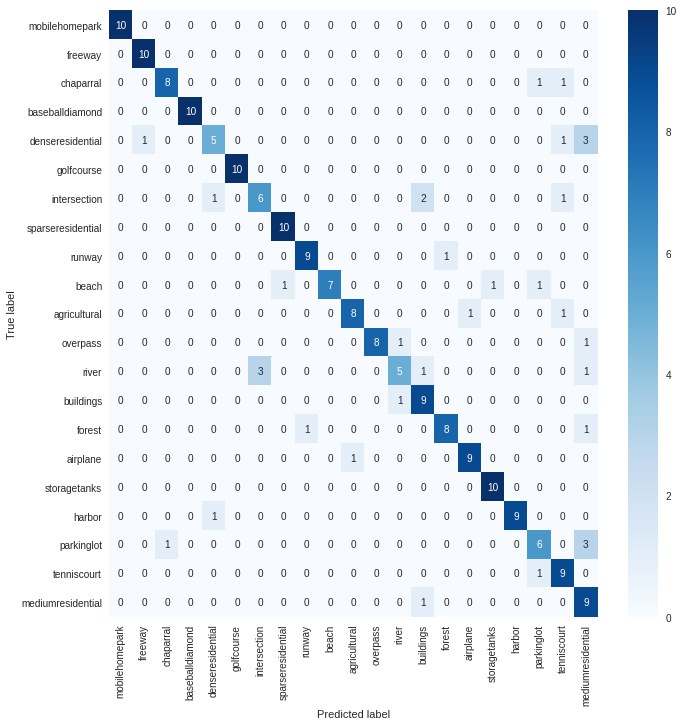

In [47]:
import tensorflow as tf
import pandas as pd
import seaborn as sns

con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
#con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat,
                     index = class_names, 
                     columns = class_names)

figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()